In [208]:
import warnings
warnings.filterwarnings("ignore")

import time
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [209]:
df_f = pd.read_csv('Sunspots.csv')

## Data Exploration & Wrangling

In [210]:
df_f.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [211]:
df_f.shape

(3265, 3)

In [212]:
df_f.isnull().sum()

Unnamed: 0                           0
Date                                 0
Monthly Mean Total Sunspot Number    0
dtype: int64

In [213]:
df_f.drop('Unnamed: 0', axis=1, inplace=True)

In [214]:
df_f['Date'] = pd.to_datetime(df_f['Date'])
df_f.set_index('Date', inplace=True)

In [215]:
df_f.rename(columns={'Monthly Mean Total Sunspot Number':'MMTSN'}, inplace=True)

In [216]:
df_f.head()

,MMTSN
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


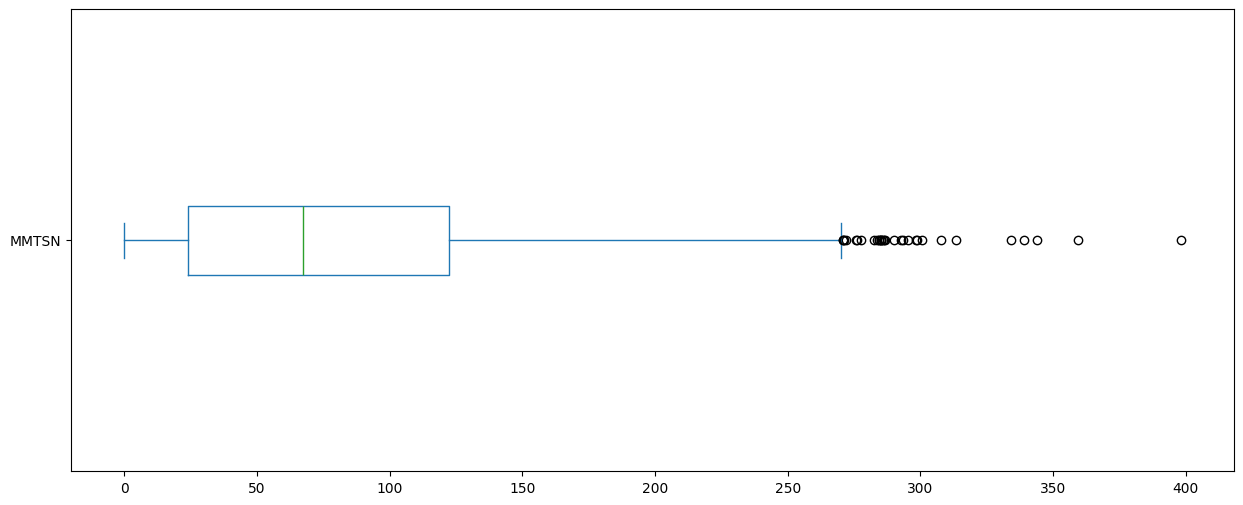

In [217]:
fig, ax = plt.subplots(figsize = (15, 6))
df_f.plot(kind='box', vert=False, ax=ax), ;

<Axes: xlabel='Date', ylabel='MMTSN'>

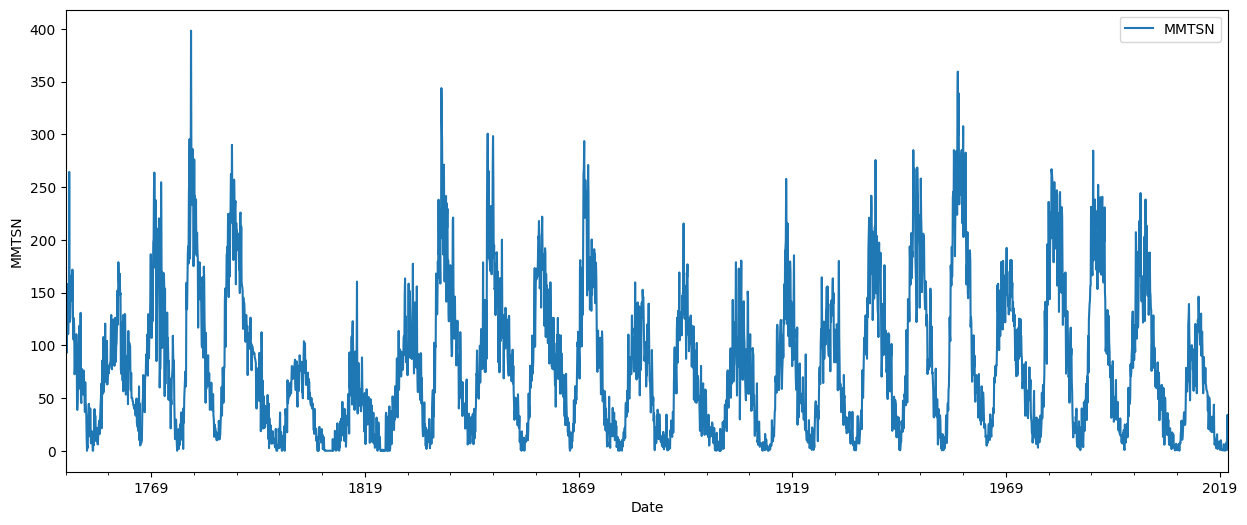

In [218]:
fig, ax = plt.subplots(figsize = (15, 6))
df_f.plot(xlabel='Date', ylabel='MMTSN', ax=ax)

<Axes: xlabel='Date', ylabel='MMTSN'>

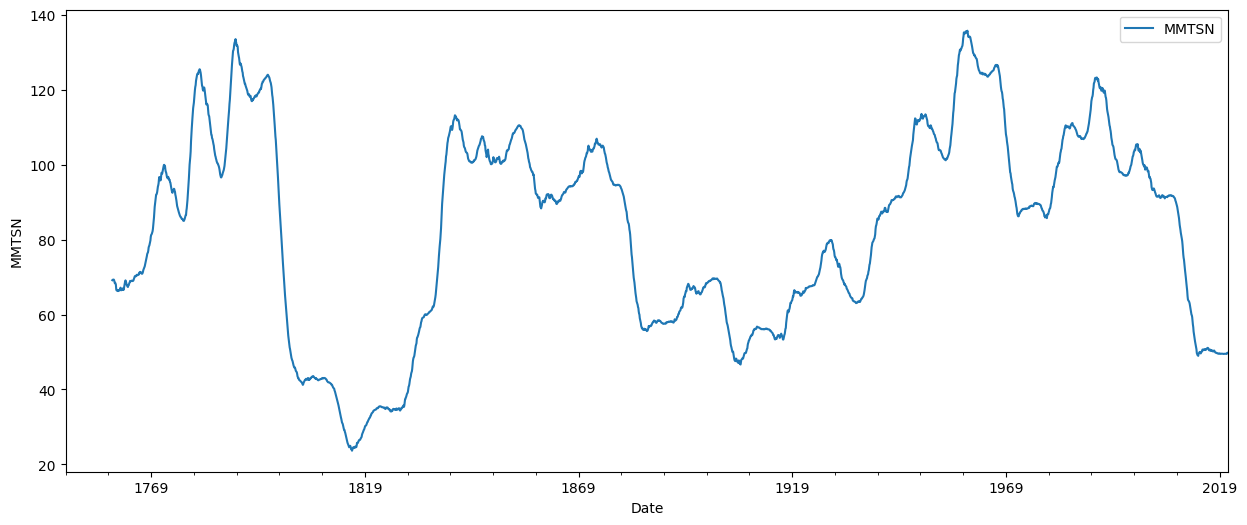

In [219]:
fig, ax = plt.subplots(figsize = (15, 6))
df_f.rolling(132).mean().plot(ax=ax, ylabel='MMTSN')

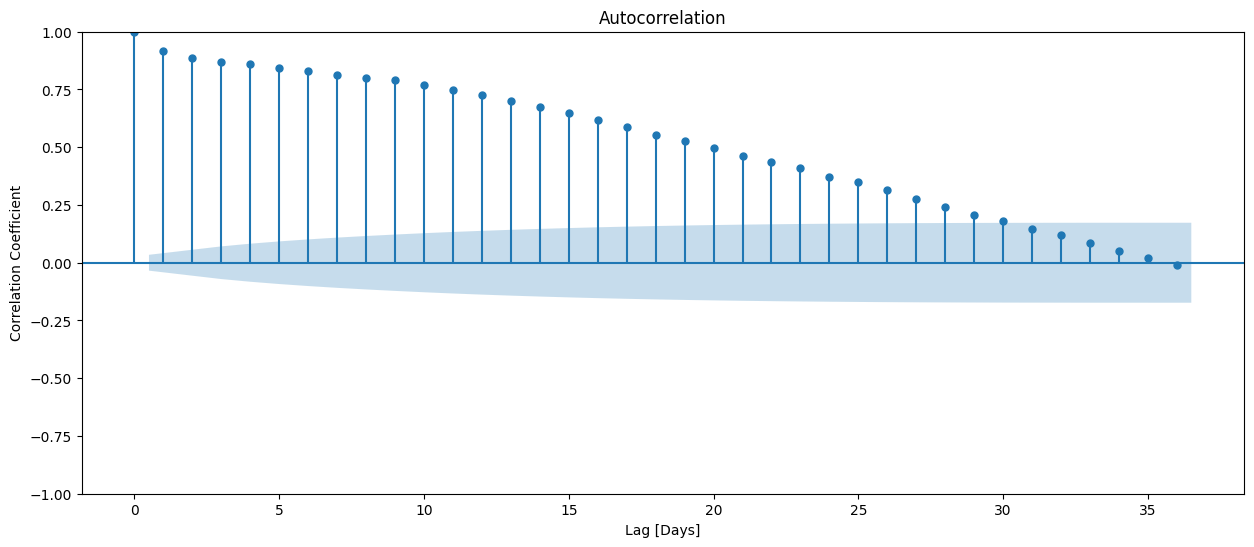

In [220]:
fig, ax = plt.subplots(figsize = (15, 6))
plot_acf(df_f, ax=ax);
plt.xlabel("Lag [Days]")
plt.ylabel("Correlation Coefficient");

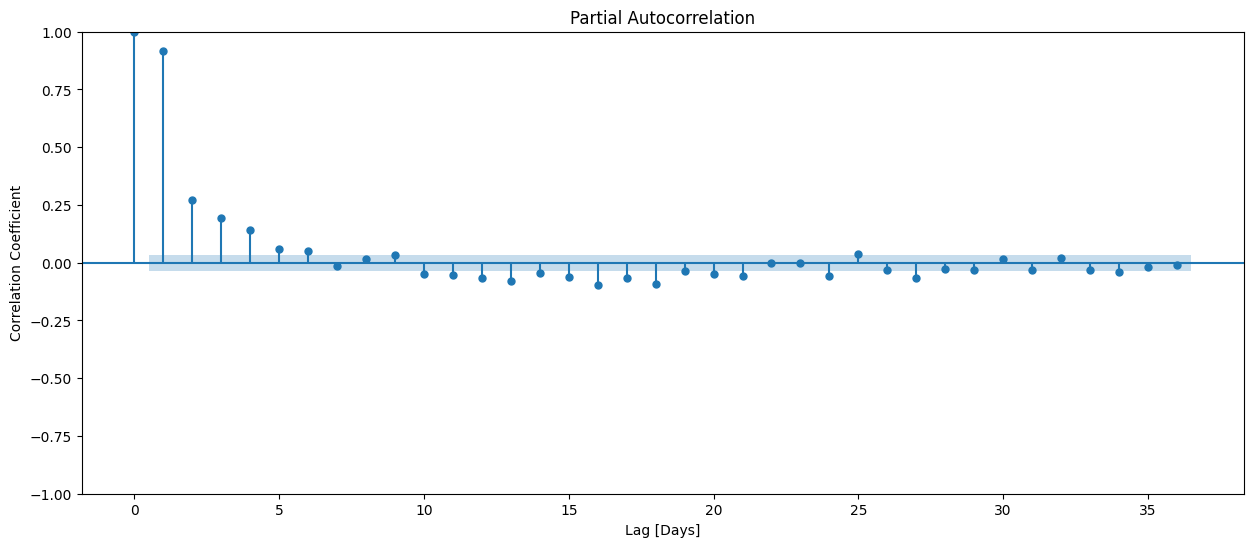

In [221]:
fig, ax = plt.subplots(figsize = (15, 6))
plot_pacf(df_f, ax=ax);
plt.xlabel("Lag [Days]")
plt.ylabel("Correlation Coefficient");

## Data Preprocessing

In [222]:
def create_lagged_features(data, lags):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'MMTSN_L{lag}'] = df['MMTSN'].shift(lag)
    df.dropna(inplace=True)
    return df

In [223]:
df = create_lagged_features(df_f, 27)

In [224]:
df.head()

,MMTSN,MMTSN_L1,MMTSN_L2,MMTSN_L3,MMTSN_L4,MMTSN_L5,MMTSN_L6,MMTSN_L7,MMTSN_L8,MMTSN_L9,...,MMTSN_L18,MMTSN_L19,MMTSN_L20,MMTSN_L21,MMTSN_L22,MMTSN_L23,MMTSN_L24,MMTSN_L25,MMTSN_L26,MMTSN_L27
Date,,,,,,,,,,,,,,,,,,,,,
1751-04-30,94.0,75.5,72.5,116.7,125.7,105.5,109.5,152.0,171.7,142.3,...,125.8,126.5,110.5,158.0,139.2,141.7,92.8,116.7,104.3,96.7
1751-05-31,101.2,94.0,75.5,72.5,116.7,125.7,105.5,109.5,152.0,171.7,...,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8,116.7,104.3
1751-06-30,84.5,101.2,94.0,75.5,72.5,116.7,125.7,105.5,109.5,152.0,...,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8,116.7
1751-07-31,110.5,84.5,101.2,94.0,75.5,72.5,116.7,125.7,105.5,109.5,...,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8
1751-08-31,99.7,110.5,84.5,101.2,94.0,75.5,72.5,116.7,125.7,105.5,...,126.5,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7


## Data Spliting

In [225]:
cutoff = int(0.8 * len(df))
def data_split(df):    
    y = df['MMTSN']
    x = df.drop('MMTSN', axis=1)

    return x.iloc[:cutoff], x.iloc[cutoff:], y.iloc[:cutoff], y.iloc[cutoff:]

In [226]:
x_train, x_test, y_train, y_test  = data_split(df)

## Baseline Readings

In [227]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 80.03
Baseline MAE: 53.96


## Desision Tree Model

In [228]:
tree_model = DecisionTreeRegressor()
tree_model.fit(x_train, y_train);

### Results of training

In [229]:
y_pred = tree_model.predict(x_train)
training_mae = mean_absolute_error(y_train, y_pred)
print("Training MAE:", training_mae)

Training MAE: 0.0


In [230]:
train_residuals = y_train - y_pred

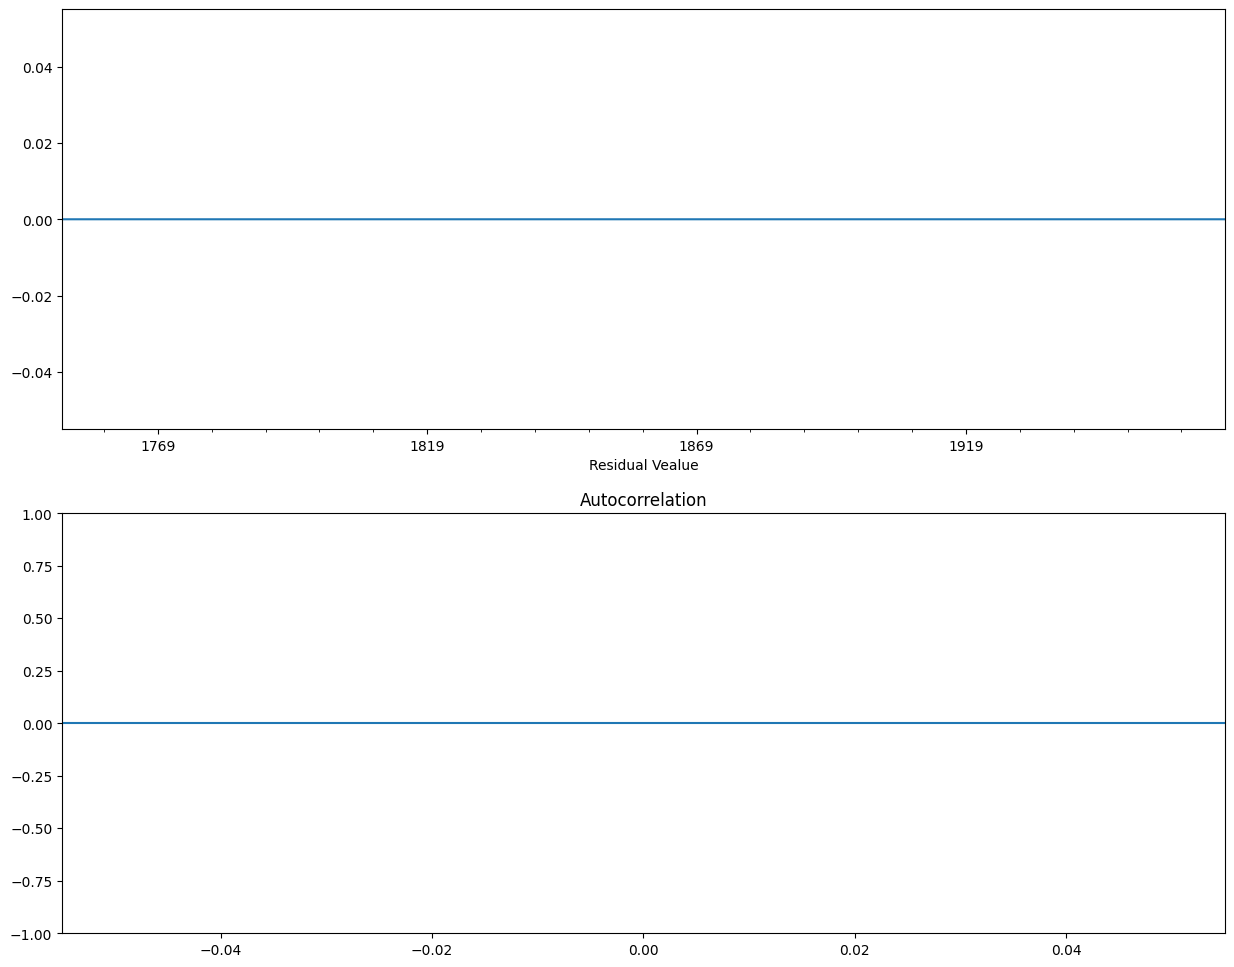

In [231]:
fig, ax = plt.subplots(2, 1,figsize=(15, 12))
train_residuals.plot(xlabel='Residual Vealue', ax=ax[0])
plot_acf(train_residuals, ax=ax[1]);

### Results of testing

In [232]:
y_test_pred = tree_model.predict(x_test)
testing_mae = mean_absolute_error(y_test, y_test_pred)
print("Testing MAE:", testing_mae)

Testing MAE: 24.41466049382716


In [233]:
test_residuals = y_test - y_test_pred
test_residuals.tail()

Date
2020-09-30   -12.0
2020-10-31   -13.3
2020-11-30    30.8
2020-12-31     3.8
2021-01-31     3.8
Name: MMTSN, dtype: float64

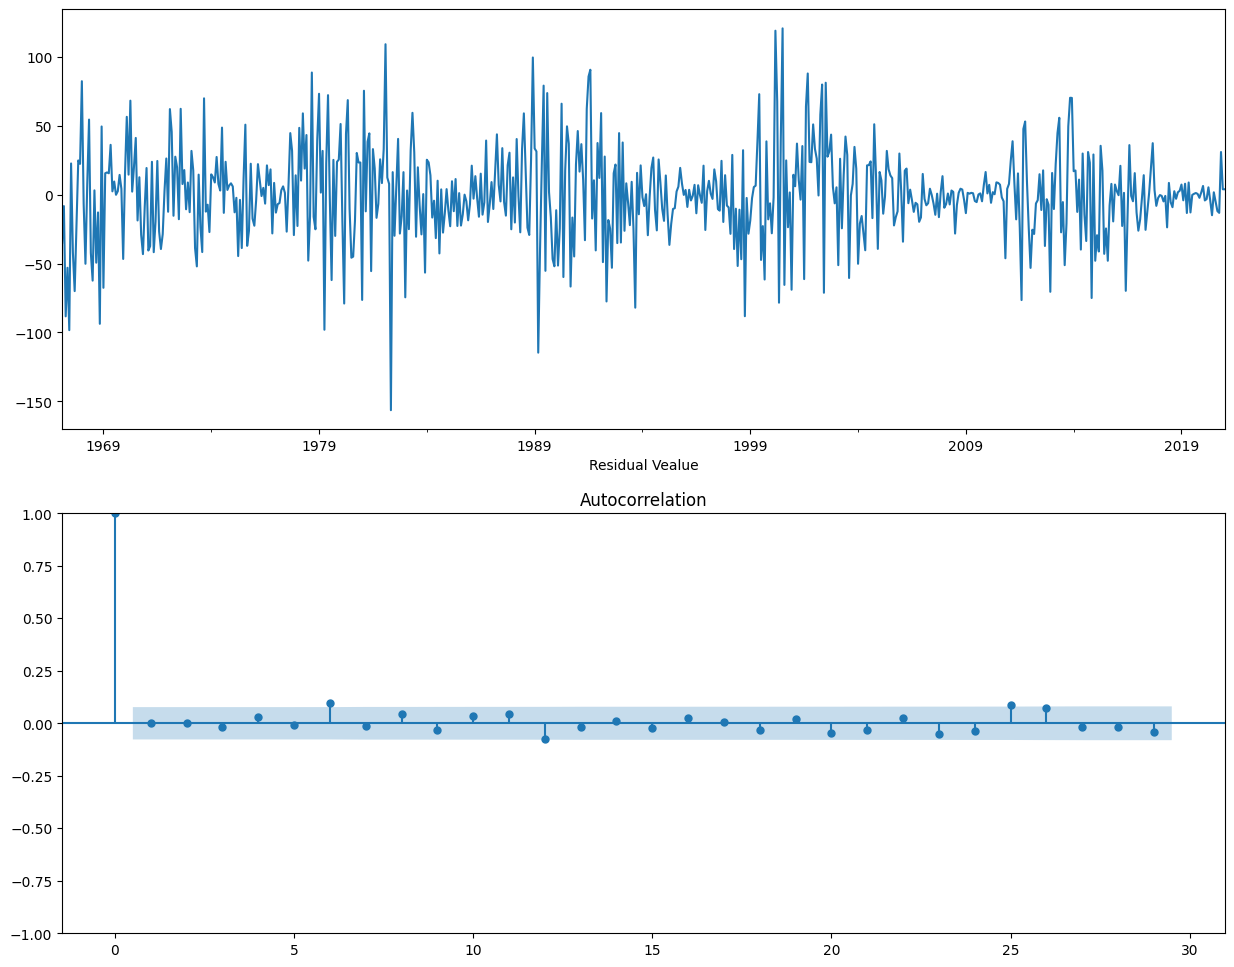

In [234]:
fig, ax = plt.subplots(2, 1,figsize=(15, 12))
test_residuals.plot(xlabel='Residual Vealue', ax=ax[0])
plot_acf(test_residuals, ax=ax[1]);

In [235]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_test_pred}, index=y_test.index
)

In [236]:
fig = px.line(df_pred_test, labels={'value':"MMTSN"})
fig.show()

### With Walk Forward Validation

In [237]:
y_pred_wfv = pd.Series()
y_history = y_train.copy()
x_history = x_train.copy()

for i in range(len(y_test)):
    tree_model = DecisionTreeRegressor()
    tree_model.fit(x_history, y_history)
    y_pred = tree_model.predict(x_test.iloc[i : i + 1])
    y_pred_wfv = pd.concat([y_pred_wfv, pd.Series(y_pred, index=y_test.index[i:i+1])])
    y_history = pd.concat([y_history, y_test.iloc[i : i + 1]])
    x_history = pd.concat([x_history, x_test.iloc[i : i + 1]])

In [238]:
testing_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Testing MAE:", testing_mae)

Testing MAE: 23.319444444444443


In [239]:
df_pred_test_wfv = pd.DataFrame(
    {"y_test": y_test, "y_pred_wfv": y_pred_wfv}, index=y_test.index
)

In [240]:
fig = px.line(df_pred_test_wfv, labels={'value':"MMTSN"})
fig.show()

## XGBoost Model

In [241]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
xgb_model.fit(x_train, y_train);

Training MAE: 2.008183207459259


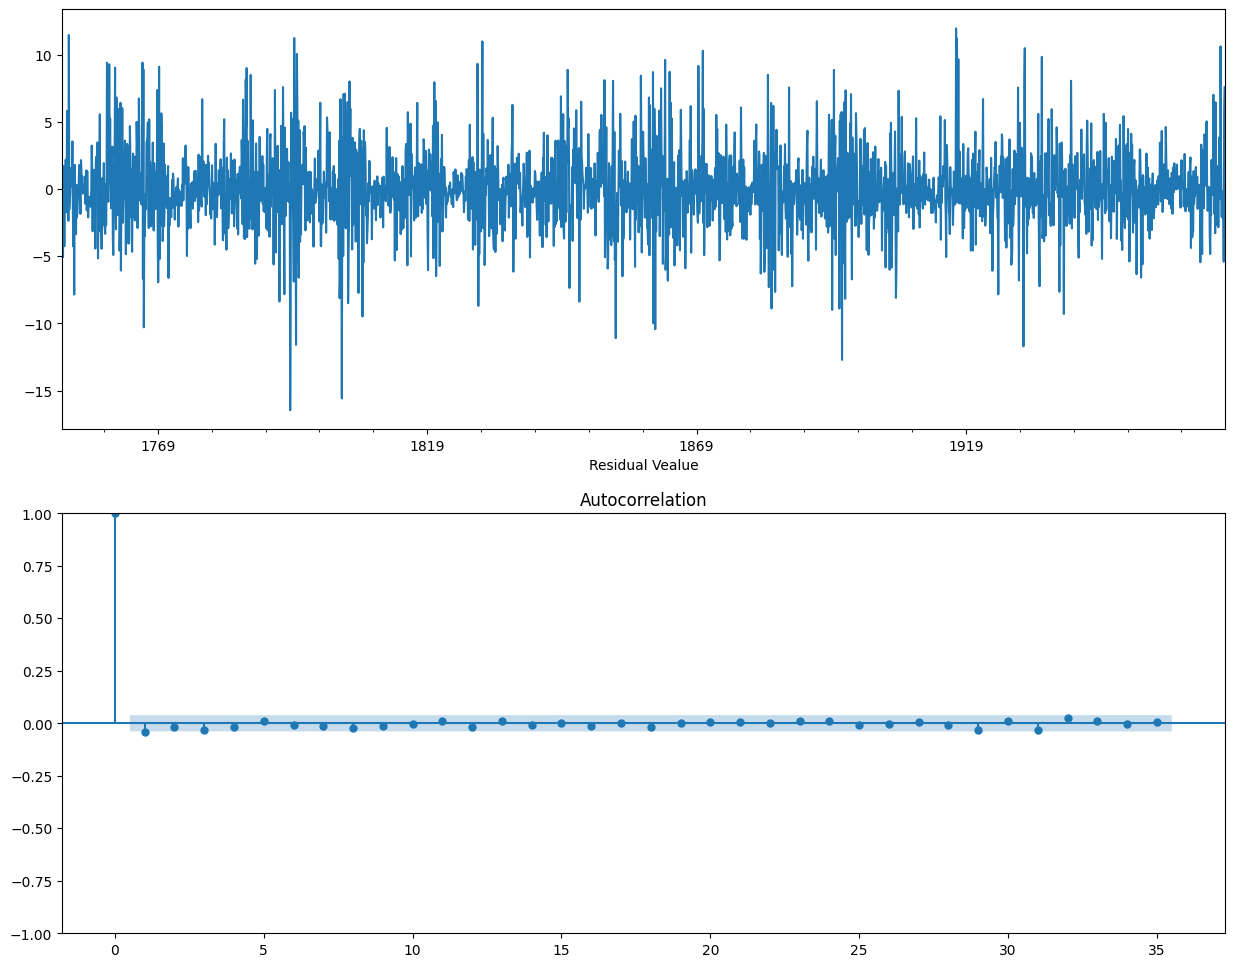

In [242]:
y_pred = xgb_model.predict(x_train)
training_mae = mean_absolute_error(y_train, y_pred)
print("Training MAE:", training_mae)

train_residuals = y_train - y_pred

fig, ax = plt.subplots(2, 1,figsize=(15, 12))
train_residuals.plot(xlabel='Residual Vealue', ax=ax[0])
plot_acf(train_residuals, ax=ax[1]);

In [243]:
xgb_pred = xgb_model.predict(x_test)
mae = mean_absolute_error(y_test, xgb_pred)
print("MAE:", mae)

MAE: 18.486946011182887


In [244]:
test_residuals = y_test - xgb_pred

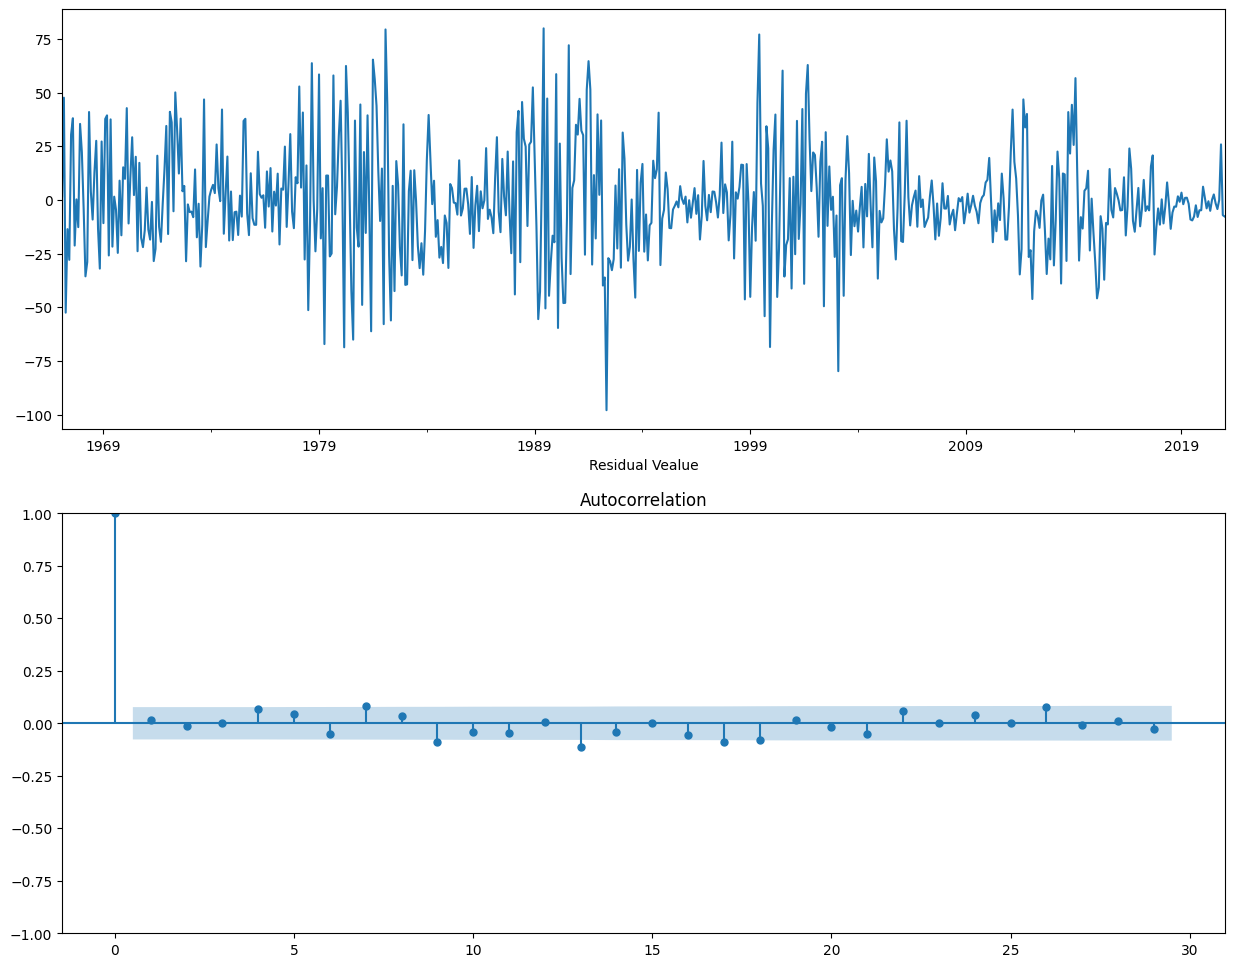

In [245]:
fig, ax = plt.subplots(2, 1,figsize=(15, 12))
test_residuals.plot(xlabel='Residual Vealue', ax=ax[0])
plot_acf(test_residuals, ax=ax[1]);

In [246]:
df_pred_xgb = pd.DataFrame(
    {"y_test": y_test, "xgb_pred":xgb_pred}, index=y_test.index
)

In [247]:
fig = px.line(df_pred_xgb, labels={'value':"MMTSN"})
fig.show()

## With Walk Forward Validation

In [248]:
y_pred_wfv = pd.Series()
y_history = y_train.copy()
x_history = x_train.copy()

for i in range(len(y_test)):
    tree_model = xgb.XGBRegressor(objective='reg:squarederror')
    tree_model.fit(x_history, y_history)
    y_pred = tree_model.predict(x_test.iloc[i : i + 1])
    y_pred_wfv = pd.concat([y_pred_wfv, pd.Series(y_pred, index=y_test.index[i:i+1])])
    y_history = pd.concat([y_history, y_test.iloc[i : i + 1]])
    x_history = pd.concat([x_history, x_test.iloc[i : i + 1]])

In [249]:
mae = mean_absolute_error(y_test, y_pred_wfv)
print("MAE:", mae)

MAE: 17.88070303284


In [250]:
df_pred_xgb_wfv = pd.DataFrame(
    {"y_test": y_test, "y_pred_xgb_wfv": y_pred_wfv}, index=y_test.index
)

In [251]:
fig = px.line(df_pred_xgb_wfv, labels={'value':"MMTSN"})
fig.show()

## ARIMA Model

In [261]:
# New cutoff to save some Time
cutoff = int(len(df_f)*0.98)
y_train = df_f[:cutoff]
y_test = df_f[cutoff:]

In [253]:
p_params = range(0, 28, 9)
q_params = range(0, 3, 1)

### Hyperparameter Tuning

In [254]:
mae_grid = dict()

for p in p_params:
    mae_grid[p] = list()

    for q in q_params:
        order = (p, 0, q)
        start_time = time.time()
        model = ARIMA(y_train, order=order).fit()
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        y_pred = model.predict()
        mae = mean_absolute_error(y_train, y_pred)
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (0, 0, 0) in 0.57 seconds.
Trained ARIMA (0, 0, 1) in 0.48 seconds.
Trained ARIMA (0, 0, 2) in 0.7 seconds.
Trained ARIMA (9, 0, 0) in 1.57 seconds.
Trained ARIMA (9, 0, 1) in 4.07 seconds.
Trained ARIMA (9, 0, 2) in 6.55 seconds.
Trained ARIMA (18, 0, 0) in 7.81 seconds.
Trained ARIMA (18, 0, 1) in 18.05 seconds.
Trained ARIMA (18, 0, 2) in 15.18 seconds.
Trained ARIMA (27, 0, 0) in 24.86 seconds.
Trained ARIMA (27, 0, 1) in 60.01 seconds.
Trained ARIMA (27, 0, 2) in 54.86 seconds.

{0: [55.15824619413066, 36.29146704644101, 29.165169207048454], 9: [18.149993009759143, 18.144446096909462, 18.1409145059637], 18: [17.79243778467324, 17.72678717180944, 17.727365761843988], 27: [17.643798331894384, 17.660933330021034, 17.643620538813515]}


In [255]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,9,18,27
0,55.1582,18.1500,17.7924,17.6438
1,36.2915,18.1444,17.7268,17.6609
2,29.1652,18.1409,17.7274,17.6436


Text(0.5, 1.0, 'ARMA Grid Search (Criterion: MAE)')

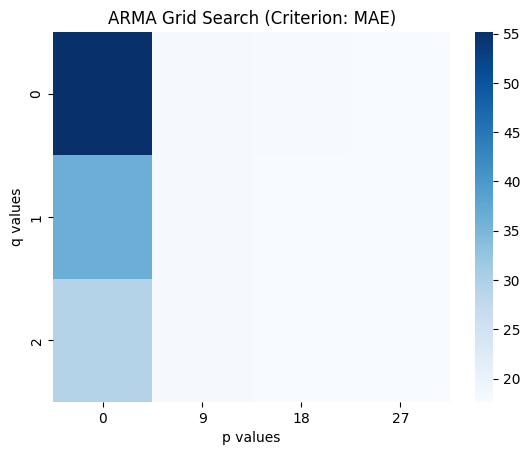

In [256]:
sns.heatmap(mae_df, cmap='Blues')
plt.xlabel('p values')
plt.ylabel('q values')
plt.title('ARMA Grid Search (Criterion: MAE)')

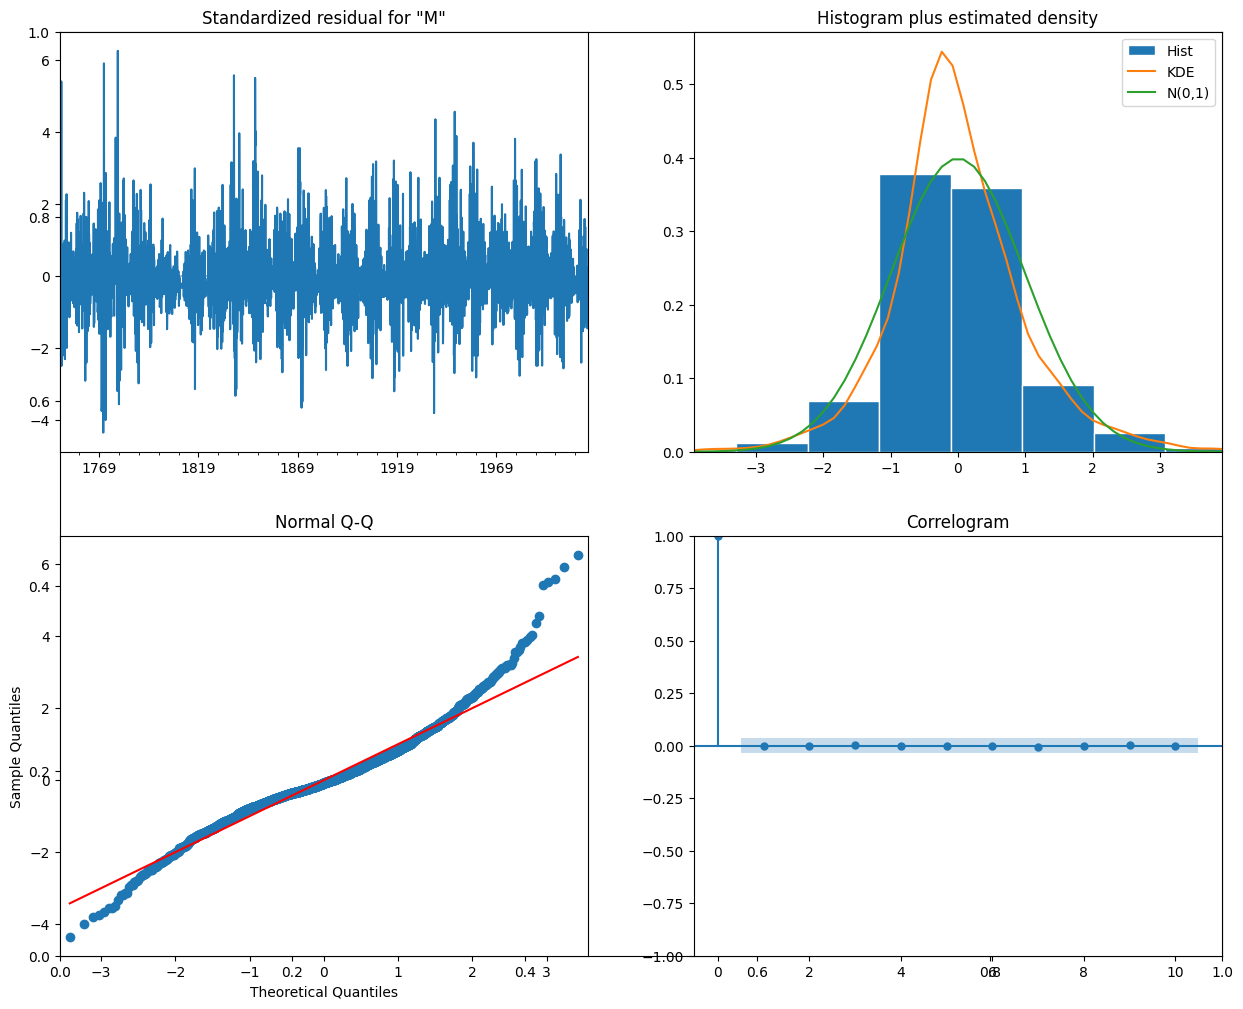

In [257]:
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig = fig);

### Walk Forward Validation for ARIMA Model

In [ ]:
def clean_series(data):
    if isinstance(data, pd.DataFrame):
        series = data.iloc[:, -1]
    elif isinstance(data, pd.Series):
        series = data
    else:
        raise TypeError("Input must be a pandas DataFrame or Series")
    series = pd.to_numeric(series, errors='coerce')
    series = series.dropna()
    return series

y_train = clean_series(y_train)
y_test = clean_series(y_test)

y_pred_wfv = pd.Series()
history = y_train.copy()

for i in range(len(y_test)):
    history = clean_series(history)
    
    model = ARIMA(history, order=(27, 0, 0)).fit()
    next_pred = model.forecast()
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
    next_date = y_test.index[i]
    history = pd.concat([history, pd.Series({next_date: y_test.iloc[i]})])

In [259]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 7.25


In [260]:
df_predictions = pd.DataFrame(
    {'y_pred_wfv':y_pred_wfv, 'y_test':y_test}
)
fig = px.line(df_predictions, labels={'value':'P2'})
fig.show()